# Import Libraries / Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Reshape, dot, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax, Adagrad
from tensorflow.keras.losses import mean_squared_error as mse
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import tensorflow_hub as hub

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel, AutoConfig

import torch

pd.options.display.max_colwidth = 200


In [2]:
df_sweetmarias = pd.read_csv('cleaned_sweetmarias.csv')

In [3]:
df_sweetmarias.head(5)

,Name,URL,Description,Process,Variety,all_combined,exlc_name_combined
0,Burundi Commune Mutambu,https://www.sweetmarias.com/burundi-commune-mutambu-6644.html,"Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full City+. Good for espresso.",Wet Washed,Bourbon,"Burundi Commune Mutambu, Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full...","Burundi Commune Mutambu, Such a versatile Burundi, a neutral sweetness is accented by complex baking spices, creamed honey, loose leaf black tea and bittering cocoa when roasted dark. City to Full..."
1,Burundi Dry Process Gaterama Agahore,https://www.sweetmarias.com/burundi-dry-process-gaterama-agahore-6751.html,"Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fruit and earthy accents. City+ to Full C...",Dry Natural,Bourbon,"Burundi Dry Process Gaterama Agahore, Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fru...","Burundi Dry Process Gaterama Agahore, Unapologetic ""dry process"" flavor that should satisfy those longing for berry-toned naturals ala ""Harrar"". Blackberry reduction, maple syrup, rustic dried fru..."
2,Burundi Dry Process Kibingo,https://www.sweetmarias.com/burundi-dry-process-kibingo-6749.html,"Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark cacao bar with crisped rice. ...",Dry Natural,Bourbon,"Burundi Dry Process Kibingo, Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark ...","Burundi Dry Process Kibingo, Cooked fruit and wheat flavors that bring to mind raspberry pie, hints of barley malt syrup and dried prune. Soft acidity and bittersweet at Full City, a note of dark ..."
3,Burundi Honey Process Gahahe,https://www.sweetmarias.com/burundi-honey-process-gahahe-6747.html,"Sweet, clean cup character like wet process Burundi, burned sugar sweetness, bergamot orange aroma, old fashioned spice cookies, and an acidic impression like strong black tea. City to Full City. ...",Honey,Bourbon,"Burundi Honey Process Gahahe, Sweet, clean cup character like wet process Burundi, burned sugar sweetness, bergamot orange aroma, old fashioned spice cookies, and an acidic impression like strong ...","Burundi Honey Process Gahahe, Sweet, clean cup character like wet process Burundi, burned sugar sweetness, bergamot orange aroma, old fashioned spice cookies, and an acidic impression like strong ..."
4,Burundi Kabarore Commune Yandaro,https://www.sweetmarias.com/burundi-kabarore-commune-yandaro-6746.html,"Lighter roasts draw out potent aromatic, like whole clove and all spice, unrefined molasses sweetness, cola, and a brisk flavor of black tea with lemon. City to Full City+. Good for espresso.",Wet Washed,Bourbon,"Burundi Kabarore Commune Yandaro, Lighter roasts draw out potent aromatic, like whole clove and all spice, unrefined molasses sweetness, cola, and a brisk flavor of black tea with lemon. City to F...","Burundi Kabarore Commune Yandaro, Lighter roasts draw out potent aromatic, like whole clove and all spice, unrefined molasses sweetness, cola, and a brisk flavor of black tea with lemon. City to F..."


# Brief Introduction

For Part 2, the aim is to leverage the text data from the OCR tool to generate recommendations of related coffees to buy from Sweet Marias. For example, if the OCR tool generates these words `['plum, berry, caturra, washed']`, we should ideally be recommded 5 coffees with very similar descriptions from Sweet Marias. 

There are a few different NLP/deep-learning methods that I will try out in this section. These are a **baseline TF-IDF model**, a **feed-forward neural network auto-encoder**, and a **BERT transformer**.

This project is using content-based recommendation and recommendations are ranked based on the cosine distance of the word vectors generated from the 'query' (OCR text) and each coffee description from Sweet Marias.

# Pre-processing

In terms of pre-processing, there a few basic text cleaning steps (lowercase text, removing \n etc.) followed by a simple tokenization (with option of lemmatization). Tokenization only applies to the first two models as BERT has an in-built tokenization process in their architecture.

In [4]:
new_stop_words = ['coffee','bean','beans','roaster','roasters']
total_stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [5]:
def clean_text(text):
    '''Function to apply basic cleaning'''
    
    text = text.lower() #lowercase all text
    text = re.sub(r'(\r\n|\r|\n)',' ',text) #remove \r and \n
    text = re.sub(r'[^\w\s]',' ',text) #remove all non-alphanumeric characters
    
    return text

In [6]:
def tokenizer(document, stopwords=total_stop_words, lemmatize=True):
    '''Function to tokenize words with option to apply lemmatization'''
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        
        tokens = [lemmatizer.lemmatize(i) for i in word_tokenize(document)]
    else:
        tokens = [i for i in word_tokenize(document)]
    
    tokens = [i for i in tokens if i not in stopwords]
    tokens = ' '.join(tokens)
    
    return tokens

In [7]:
df_sweetmarias['cleaned_combined'] = df_sweetmarias['exlc_name_combined'].apply(clean_text)

In [8]:
df_sweetmarias['tok_lem_combined'] = df_sweetmarias['cleaned_combined'].apply(lambda x: tokenizer(x, stopwords=total_stop_words, lemmatize=True))

## Functions

In [9]:
def recommend_coffee_from_description_tfidf(query, model_embed):
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(vectorize_query, model_embed))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [10]:
def recommend_coffee_from_description_ae(query, auto_encode_embedding):
    
    #Embed query
    clean_query = clean_text(query)
    vectorize_query = tfidf.transform([clean_query]) #apply tfidf transform on query
    
    #Predict
    query_predict = embedding.predict(vectorize_query)
    
    #Matrix of similarity between query and database
    similarity_matrix = pd.DataFrame(cosine_similarity(
            query_predict,auto_encode_embedding))
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

In [11]:
def recommend_coffee_from_description_BERT(matrix):
    
    similarity_matrix = pd.DataFrame(matrix)
    
    #New column of 'similarity_score'
    similar_items = pd.DataFrame(similarity_matrix.T)
    similar_items.columns = ["similarity_score"]
    similar_items = similar_items.sort_values('similarity_score', ascending=False)
    similar_items.reset_index(inplace=True)
    
    #Use index as an 'item_id' 
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_coffees = pd.DataFrame(similar_items.to_dict())
    similar_coffees.set_index('item_id', inplace=True)
    
    #List top recommendations 
    similar_df = pd.merge(df_sweetmarias, similar_coffees, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    return similar_df[['Name','Description','Process','Variety','similarity_score']].head(5)

# Query

**Placeholder for now** - this will be linked with OCR text data from Part 1

In [12]:
query = 'plum, berry, caturra, washed'

# TF-IDF

In [13]:
tfidf = TfidfVectorizer(stop_words=total_stop_words, binary=True)
tfidf_matrix = tfidf.fit_transform(df_sweetmarias['tok_lem_combined'].values)
tfidf_matrix.shape

(343, 1555)

In [14]:
tfidf_matrix_array = tfidf_matrix.toarray()

In [15]:
recommend_coffee_from_description_tfidf(query, tfidf_matrix_array)

,Name,Description,Process,Variety,similarity_score
328,Colombia Urrao Valle de Penderisco,"Brown sugar and roast bittering low tones open up to accents of red berry, date syrup, plum, sweetened cocoa, and black tea-like acidity that's somewhere between mild and moderate. City to Full Ci...",Wet Washed,"Caturra, Typica",0.282051
327,Colombia Urrao Valle de Penderisco,"Molasses, demurara sugar, moderate brightness, accents of berry and hibiscus flower tea. Dark roasts boast heavy-handed cocoa roast flavors and plum. City+ to Full City+. Good for espresso.",Wet Washed,"Caturra, Bourbon, Heirloom",0.265627
103,Rwanda Dry Process Nyakabingo,"Middle roasts move beyond molasses sweetness, to fruit and spice flavors, notes of berry-infused dark chocolate, plum, overripe citrus, and a hint of heart of palm in the finish. City+ to Full City.",Dry Natural,Bourbon,0.227992
306,Colombia Caicedo Las Alegrias,"A cup with intimations of dried fruit against a backdrop of rustic, unrefined sugar sweetness, hints of dried raisin and plum, tea-like tannic acidity. Chocolatey dark roast. City to Full City+.",Wet Washed,"Caturra, Typica, Modern Hybrids",0.216292
185,Guatemala Proyecto Xinabajul Donaldo Villatoro,"An aromatic Guatemalan coffee with brisk acidity, toasted sugar sweetness, and flavor notes of warming spices, Earl Grey tea, dried plum and milk chocolate. City to Full City.",Wet Washed,"Caturra, Bourbon, Typica",0.205547


# Feed-Forward Auto-Encoder

In [16]:
input_size = tfidf_matrix_array.shape[1]
intermediate_size = 512
code_size = 48

def auto_encoder():
    
    #Encode
    model = Sequential()
    model.add(Dense(intermediate_size,input_shape=(input_size,))) 
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(code_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_encoder2'))
    model.add(Activation('relu'))
    
    #Decode
    model.add(Dense(code_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder1'))
    model.add(Activation('relu'))
    
    
    model.add(Dense(intermediate_size))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=1, name='bn_decoder2'))
    model.add(Activation('relu'))
    
    model.add(Dense(input_size,))
    model.add(Activation('sigmoid'))
    return model

In [17]:
auto_encode = auto_encoder() 

2021-11-05 02:50:25.889747: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 02:50:25.891886: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [18]:
auto_encode.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               796672    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
bn_encoder1 (BatchNormalizat (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
bn_encoder2 (BatchNormalizat (None, 48)                1

In [19]:
train, test = train_test_split(tfidf_matrix_array, random_state=42)

In [20]:
auto_encode.compile(optimizer='Adam', loss='mse')
history = auto_encode.fit(train, train, #train, train because targets of the autoencoder are the same as the input
                          epochs = 75,
                          batch_size = 128,
                          shuffle = True,
                          validation_data = (test, test),
                          verbose = 1)

Train on 257 samples, validate on 86 samples
Epoch 1/75
257/257 [==============================] - 4s 14ms/sample - loss: 0.2417 - val_loss: 0.2460
Epoch 2/75
257/257 [==============================] - 0s 687us/sample - loss: 0.1432 - val_loss: 0.2439
Epoch 3/75
257/257 [==============================] - 0s 657us/sample - loss: 0.0802 - val_loss: 0.2408
Epoch 4/75
257/257 [==============================] - 0s 636us/sample - loss: 0.0432 - val_loss: 0.2366
Epoch 5/75
257/257 [==============================] - 0s 626us/sample - loss: 0.0231 - val_loss: 0.2314
Epoch 6/75
257/257 [==============================] - 0s 600us/sample - loss: 0.0135 - val_loss: 0.2254
Epoch 7/75
257/257 [==============================] - 0s 596us/sample - loss: 0.0086 - val_loss: 0.2188
Epoch 8/75
257/257 [==============================] - 0s 609us/sample - loss: 0.0057 - val_loss: 0.2119
Epoch 9/75
257/257 [==============================] - 0s 604us/sample - loss: 0.0044 - val_loss: 0.2048
Epoch 10/75
257/257 

In [21]:
train_loss = history.history["loss"]
test_loss = history.history['val_loss']
epoch_labels = history.epoch

losses = pd.DataFrame(data=list(zip(train_loss, test_loss)), columns=['train_loss', 'validation_loss'])

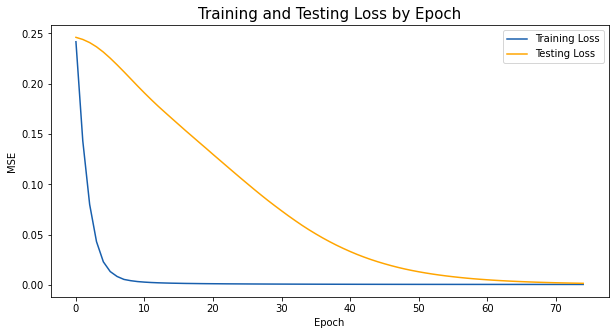

In [22]:
plt.figure(figsize=(10, 5))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('MSE', fontsize = 10)
plt.legend(fontsize = 10);


In [23]:
embedding = Model(auto_encode.inputs, auto_encode.layers[11].output)
auto_encode_embedding = embedding.predict(tfidf_matrix_array)

In [24]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

,Name,Description,Process,Variety,similarity_score
320,Colombia Pavón Finca Los Palomos,"Intense with complex raw sugar sweetness, viscous in texture and presents notes of stewed plum, black tea with a bracing lemon note, pancake syrup and bittering citrus peel in the aftertaste. City...",Wet Washed,Caturra,0.989963
5,Burundi Kayanza Dusangirijambo,"Balanced sweet and bitter flavors give way to baking spice and accents of crisp apple, raisin, Darjeeling tea, and moderate lemon-like acidity. Darker roasts have a chocolate-cherry flavor note. C...",Wet Washed,Bourbon,0.989776
45,Ethiopia Organic Nensebo Refisa,"An aromatic cup in all of our roasts, dried florals, sweet herbs, and fragrant woody incense, notes of simple syrup, orange essence, fruit gum, and grabby citrus finish. City to Full City.",Wet Washed,Heirloom,0.988940
46,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.988914
60,Kenya Kiambu Evans Farm Peaberry,"The cup is aromatic, sweet, and undoubtedly complex. Packed with unrefined sugar sweetness, cinnamon stick, orange spiced herbal tea, fragrant citrus oil, and an oak barrel, aromatic wood-like hin...",Wet Washed,Bourbon,0.988832


In [25]:
recommend_coffee_from_description_ae(query, auto_encode_embedding)

,Name,Description,Process,Variety,similarity_score
320,Colombia Pavón Finca Los Palomos,"Intense with complex raw sugar sweetness, viscous in texture and presents notes of stewed plum, black tea with a bracing lemon note, pancake syrup and bittering citrus peel in the aftertaste. City...",Wet Washed,Caturra,0.989963
5,Burundi Kayanza Dusangirijambo,"Balanced sweet and bitter flavors give way to baking spice and accents of crisp apple, raisin, Darjeeling tea, and moderate lemon-like acidity. Darker roasts have a chocolate-cherry flavor note. C...",Wet Washed,Bourbon,0.989776
45,Ethiopia Organic Nensebo Refisa,"An aromatic cup in all of our roasts, dried florals, sweet herbs, and fragrant woody incense, notes of simple syrup, orange essence, fruit gum, and grabby citrus finish. City to Full City.",Wet Washed,Heirloom,0.988940
46,Ethiopia Organic Shakiso Kayon Mountain Farm,"Unrefined sugar sweetness is cut through by a rindy citrus flavor, fruited accent notes of orange and dried strawberry, aromatic herbals, Earl Grey and hibiscus teas, and a soft floral jasmine not...",Wet Washed,Heirloom,0.988914
60,Kenya Kiambu Evans Farm Peaberry,"The cup is aromatic, sweet, and undoubtedly complex. Packed with unrefined sugar sweetness, cinnamon stick, orange spiced herbal tea, fragrant citrus oil, and an oak barrel, aromatic wood-like hin...",Wet Washed,Bourbon,0.988832


In [26]:
df_sweetmarias.iloc[25]['tok_lem_combined']

'ethiopia dry process mansur aba hikam cleaner refined cup flavor natural bodied brew articulated acidity note blueberry fig jam maple palm sugar city city dry natural heirloom'

# BERT

This is a direct implemnetation of the BERT architecture from SentenceTransformers.

The MiniLM-L6-V2 is chosen because it performs relatively fast and is pre-trained for tasks like clustering or semantic search (https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) 

In [27]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
corpus_embeddings = model.encode(df_sweetmarias['cleaned_combined'].values, convert_to_tensor=True)
query_embedding = model.encode(query, convert_to_tensor=True)

In [28]:
cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=5)

In [29]:
corpus_embeddings

tensor([[-0.4670,  0.1604, -0.3347,  ...,  0.2685,  0.2024, -0.0452],
        [-0.1314,  0.4145, -0.2295,  ..., -0.0862, -0.0200, -0.2466],
        [-0.2458, -0.0997, -0.3387,  ...,  0.0982,  0.0245, -0.3425],
        ...,
        [ 0.0760, -0.3702,  0.2874,  ..., -0.1595,  0.3335, -0.0964],
        [ 0.1106,  0.0069,  0.1477,  ..., -0.3153,  0.0882,  0.0923],
        [-0.1531, -0.0332,  0.1096,  ..., -0.3258,  0.1207,  0.1910]])

In [30]:
cos_scores.max()

tensor(0.5402)

In [31]:
top_results

torch.return_types.topk(
values=tensor([0.5402, 0.5127, 0.5114, 0.5028, 0.4891]),
indices=tensor([305, 325, 324, 216,  38]))

In [32]:
for score, idx in zip(top_results[0], top_results[1]):
    score = score.cpu().data.numpy() 
    idx = idx.cpu().data.numpy()
    display(df_sweetmarias[['Name', 'Description', 'Variety', 'Process']].iloc[idx])

Name                                                                                                                                                                                   Colombia Caicedo Gustavo Rivera
Description    Subverts your expectations of what washed coffees can taste like, flavors touch on nectarine and peach, fermented raspberry, fruit preserves, tart blueberry skins, and a long, sweet finish. City t...
Variety                                                                                                                                                                                                        Caturra
Process                                                                                                                                                                                                     Wet Washed
Name: 305, dtype: object

Name                                                                                                                                                                                   Colombia Urrao Heirloom Caturra
Description    The patient drinker will be rewarded, top notes flourish as the cup cools, dark stone fruit, berry, baking spices, brisk, black tea, atop a grounding brown sugar sweetness and Root Beer finishing ...
Variety                                                                                                                                                                                              Caturra, Heirloom
Process                                                                                                                                                                                                     Wet Washed
Name: 325, dtype: object

Name                                                                                                                                                                                        Colombia Urrao Fray Moreno
Description    This coffee is anything but 'neutral'! Berry-toned aroma, stone fruit accent of red plum, hints of mint and Yerba Mate, and a tangy-sweet pomegranate note that heightens acidic impression. City to...
Variety                                                                                                                                                                                                       Heirloom
Process                                                                                                                                                                                                     Wet Washed
Name: 324, dtype: object

Name                                                                                                                                                                                    Nicaragua Dipilto Monte Libano
Description    A walnut note is enveloped by core flavors of brown sugar and bittersweet chocolate. Big body, the potential for heavy chocolate roast flavors, and mild mannered acidity. City+ to Full City+. Good...
Variety                                                                                                                                                                                                        Caturra
Process                                                                                                                                                                                                     Wet Washed
Name: 216, dtype: object

Name                                                                                                                                                                                      Ethiopia Guji Hambela Dabaye
Description    Impressive sweetness, demurara sugar, cream soda, mild fruited accents of nectarine and lemon, and a touch of clove in aroma. Peach-like acidity helps build out the fruited impressions. City to Fu...
Variety                                                                                                                                                                                                       Heirloom
Process                                                                                                                                                                                                     Wet Washed
Name: 38, dtype: object

## Work in progress - adjusting BERT 

In [33]:
from transformers import AutoTokenizer, AutoModel, pipeline
from tqdm import tqdm


Code from:

https://towardsdatascience.com/build-a-text-recommendation-system-with-python-e8b95d9f251c

https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2



In [34]:
BERT_BATCH_SIZE = 4
MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

seed=42

class BertModel:
    def __init__(self, model_name, device=-1, small_memory=True, batch_size=BERT_BATCH_SIZE):
        self.model_name = model_name
        self._set_device(device)
        self.small_device = 'cpu' if small_memory else self.device
        self.batch_size = batch_size
        self.load_pretrained_model()

    def _set_device(self, device):
        '''Can run on GPU if available'''
        
        if device == -1 or device == 'cpu':
            self.device = 'cpu'
        elif device == 'cuda' or device == 'gpu':
            self.device = 'cuda'
        elif isinstance(device, int) or isinstance(device, float):
            self.device = 'cuda'
        else:  # default
            self.device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")

    def load_pretrained_model(self):
        '''Using AutoTokenizer and AutoModel from Hugging Face'''
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        device = -1 if self.device == 'cpu' else 0
        self.pipeline = pipeline('feature-extraction',
                                 model=self.model, tokenizer=self.tokenizer, device=device)

    def fit_transform(self, data):
        """ Create the embedded matrice from original sentences """
        nb_batches = 1 if (len(data) < self.batch_size) else len(data) // self.batch_size
        batches = np.array_split(data, nb_batches)
        mean_pooled = []
        for batch in tqdm(batches, total=len(batches), desc='Training...'):
            mean_pooled.append(self.transform(batch))
        mean_pooled_tensor = torch.tensor(len(data), dtype=float).to(self.small_device)
        mean_pooled = torch.cat(mean_pooled, out=mean_pooled_tensor)
        self.embed_mat = mean_pooled

    @staticmethod
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(
            -1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def transform(self, data):
        if 'str' in data.__class__.__name__:
            data = [data]
        data = list(data)
        token_dict = self.tokenizer(
            data,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt")
        token_dict = self.to(token_dict, self.device)
        with torch.no_grad():
            token_embed = self.model(**token_dict)
        # each of the 512 token has a 768 or 384-d vector depends on model)
        attention_mask = token_dict['attention_mask']
        # average pooling of masked embeddings
        mean_pooled = self.mean_pooling(
            token_embed, attention_mask)
        mean_pooled = mean_pooled.to(self.small_device)
        return mean_pooled
    
    def to(self, data: dict, device: str):
        """Send all values to device by calling v.to(device)"""
        data = {k: v.to(device) for k, v in data.items()}
        return data

    def predict(self, in_sentence, topk=5):
        input_vec = self.transform(in_sentence)
        mat = cosine_similarity(input_vec, self.embed_mat)
        return mat

In [35]:
bert_model = BertModel(model_name=MODEL_NAME, batch_size=BERT_BATCH_SIZE)
bert_model.fit_transform(df_sweetmarias['cleaned_combined'].values)

Training...: 100%|██████████████████████████████| 85/85 [00:06<00:00, 13.81it/s]


In [36]:
bert_cos_sim = bert_model.predict(query)

In [37]:
recommend_coffee_from_description_BERT(bert_cos_sim)

,Name,Description,Process,Variety,similarity_score
305,Colombia Caicedo Gustavo Rivera,"Subverts your expectations of what washed coffees can taste like, flavors touch on nectarine and peach, fermented raspberry, fruit preserves, tart blueberry skins, and a long, sweet finish. City t...",Wet Washed,Caturra,0.540226
325,Colombia Urrao Heirloom Caturra,"The patient drinker will be rewarded, top notes flourish as the cup cools, dark stone fruit, berry, baking spices, brisk, black tea, atop a grounding brown sugar sweetness and Root Beer finishing ...",Wet Washed,"Caturra, Heirloom",0.512740
324,Colombia Urrao Fray Moreno,"This coffee is anything but 'neutral'! Berry-toned aroma, stone fruit accent of red plum, hints of mint and Yerba Mate, and a tangy-sweet pomegranate note that heightens acidic impression. City to...",Wet Washed,Heirloom,0.511422
216,Nicaragua Dipilto Monte Libano,"A walnut note is enveloped by core flavors of brown sugar and bittersweet chocolate. Big body, the potential for heavy chocolate roast flavors, and mild mannered acidity. City+ to Full City+. Good...",Wet Washed,Caturra,0.502826
38,Ethiopia Guji Hambela Dabaye,"Impressive sweetness, demurara sugar, cream soda, mild fruited accents of nectarine and lemon, and a touch of clove in aroma. Peach-like acidity helps build out the fruited impressions. City to Fu...",Wet Washed,Heirloom,0.489120


In [27]:
query = 'plum, berry, washed, caturra'

In [28]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [29]:
bert_query = bert_tokenizer(query, padding="max_length", truncation=True)

In [30]:
def tokenize_function(document):
    return bert_tokenizer(document, padding="max_length", truncation=True)

In [31]:
df_sweetmarias['bert_combined'] = df_sweetmarias['cleaned_combined'].apply(lambda x: tokenize_function(x))

In [104]:
train, test = train_test_split(df_sweetmarias['bert_combined'], random_state=42)

In [36]:
# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

# def get_bert_embeddings(text, encoder):
    

#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
#     encoder_inputs = preprocessor(text_input)
#     ouputs = encoder(encoder_inputs)
#     embedding_model = tf.keras.Model(text_input, outputs['pooled_output'])
#     sentences = tf.constant([text])
#     return embedding_model(sentences)

# df_sweetmarias['encodings'] = df_sweetmarias['bert_combined'].apply(lambda x: get_bert_embeddings(x, encoder))


In [173]:
# BERT_BATCH_SIZE = 4
# MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

# class BertModel:
#     def __init__(self, model_name, device=-1, small_memory=True, batch_size=BERT_BATCH_SIZE):
#         self.model_name = model_name
#         self._set_device(device)
#         self.small_device = 'cpu' if small_memory else self.device
#         self.batch_size = batch_size
#         self.load_pretrained_model()

#     def _set_device(self, device):
#         if device == -1 or device == 'cpu':
#             self.device = 'cpu'
#         elif device == 'cuda' or device == 'gpu':
#             self.device = 'cuda'
#         elif isinstance(device, int) or isinstance(device, float):
#             self.device = 'cuda'
#         else:  # default
#             self.device = torch.device(
#                 "cuda" if torch.cuda.is_available() else "cpu")

#     def load_pretrained_model(self):
#         self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
#         self.model = AutoModel.from_pretrained(self.model_name)
#         device = -1 if self.device == 'cpu' else 0
#         self.pipeline = pipeline('feature-extraction',
#                                  model=self.model, tokenizer=self.tokenizer, device=device)

#     def fit_transform(self, data):
#         """ Create the embedded matrice from original sentences """
#         nb_batchs = 1 if (len(data) < self.batch_size) else len(
#             data) // self.batch_size
#         batchs = np.array_split(data, nb_batchs)
#         mean_pooled = []
#         for batch in tqdm(batchs, total=len(batchs), desc='Training...'):
#             mean_pooled.append(self.transform(batch))
#         mean_pooled_tensor = torch.tensor(
#             len(data), dtype=float).to(self.small_device)
#         mean_pooled = torch.cat(mean_pooled, out=mean_pooled_tensor)
#         self.embed_mat = mean_pooled

#     @staticmethod
#     def mean_pooling(model_output, attention_mask):
#         token_embeddings = model_output[0]
#         input_mask_expanded = attention_mask.unsqueeze(
#             -1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

#     def transform(self, data):
#         if 'str' in data.__class__.__name__:
#             data = [data]
#         data = list(data)
#         token_dict = self.tokenizer(
#             data,
#             padding=True,
#             truncation=True,
#             max_length=512,
#             return_tensors="pt")
#         token_dict = self.to(token_dict, self.device)
#         with torch.no_grad():
#             token_embed = self.model(**token_dict)
#         # each of the 512 token has a 768 or 384-d vector depends on model)
#         attention_mask = token_dict['attention_mask']
#         # average pooling of masked embeddings
#         mean_pooled = self.mean_pooling(
#             token_embed, attention_mask)
#         mean_pooled = mean_pooled.to(self.small_device)
#         return mean_pooled
    
#     def to(self, data: dict, device: str):
#         """Send all values to device by calling v.to(device)"""
#         data = {k: v.to(device) for k, v in data.items()}
#         return data

#     def predict(self, in_sentence, topk=5):
#         input_vec = self.transform(in_sentence)
#         mat = cosine_similarity(input_vec, self.embed_mat)
#         # best cos sim for each token independantly
#         best_index = extract_best_indices(mat, topk=topk)
#         return best_index

In [153]:
from sentence_transformers import SentenceTransformer, models


In [ ]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [168]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
   InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

In [169]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [167]:
for i, j in enumerate(train_dataloader):
    print(j)

([{'input_ids': tensor([[ 101, 1045, 2572, 6569, 3993,  102],
        [ 101, 1045, 2572, 3407,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])}, {'input_ids': tensor([[ 101, 1045, 2572, 6517,  102,    0],
        [ 101, 1045, 2572, 2200, 3407,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]])}], tensor([0, 0]))


In [170]:
from sentence_transformers import evaluation
sentences1 = ['This list contains the first column', 'With your sentences', 'You want your model to evaluate on']
sentences2 = ['Sentences contains the other column', 'The evaluator matches sentences1[i] with sentences2[i]', 'Compute the cosine similarity and compares it to scores[i]']
scores = [0.3, 0.6, 0.2]

evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

# ... Your other code to load training data

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, evaluator=evaluator, evaluation_steps=500)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [171]:
evaluator

In [143]:
from transformers import BertForPreTraining, AdamW, BertConfig

In [144]:
model = AutoModel.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    #num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [145]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

In [146]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [147]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [148]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            test, # The validation samples.
            sampler = SequentialSampler(test), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [149]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [150]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [151]:
a = enumerate(train)
for i, j in a:
    print(j)

{'input_ids': [101, 3084, 3031, 4184, 1465, 3712, 1965, 12477, 25948, 1181, 170, 2822, 183, 4084, 8481, 27293, 1105, 5735, 1174, 1121, 1838, 1106, 3146, 3697, 1104, 5824, 6656, 182, 5326, 26895, 3216, 1129, 6234, 1143, 1181, 5077, 4063, 2236, 185, 10607, 1162, 8828, 5190, 1785, 1634, 1105, 170, 11515, 22504, 2221, 6614, 170, 18885, 1331, 1106, 1554, 1331, 3712, 2379, 8048, 13853, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [152]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']


        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


AttributeError: 'list' object has no attribute 'size'